# [01: Price Regression with LightGBM](#toc0_)

This is a dummy example on how to build an algorithm which predicts article prices based on product characteristerics.
The purpose is to employ LightGBM to solve this regression problem and predict prices according the given data labels and to understand the feature contribution of each underlying variable.

**Keywords**: LightGBM, regression modelling, price prediction, Vinted

**Table of contents**<a id='toc0_'></a>    
- [01: Price Regression with LightGBM](#toc1_)    
  - [Introduction](#toc1_1_)    
    - [LightGBM - out of the box approach](#toc1_1_1_)    
    - [Loading packages and data](#toc1_1_2_)    
  - [Preprocessing](#toc1_2_)    
    - [Taking a deeper look into size title](#toc1_2_3_)    
    - [Taking a deeper look into brand title](#toc1_2_4_)    
    - [Approaches to size titles](#toc1_2_5_)    
    - [Approaches to brand titles](#toc1_2_6_)    
  - [LightGBM regression model](#toc1_3_)    
    - [Q-Q Plot](#toc1_3_1_)    
    - [Kolmogorov-Smirnov Test](#toc1_3_2_)    
  - [Analysis of the results](#toc1_4_)    
    - [SHapley Additive exPlanations](#toc1_4_1_)    
    - [Conclusions](#toc1_4_2_)    
  - [Future work](#toc1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Introduction](#toc0_)

### <a id='toc1_1_1_'></a>[LightGBM - out of the box approach](#toc0_)

LightGBM, short for Light Gradient Boosting Machine, is a powerful and efficient gradient boosting framework developed by Microsoft.
One of the key features of LightGBM is its ability to handle large datasets with millions of samples and features efficiently. It achieves this by using a novel tree-based learning algorithm that grows trees leaf-wise rather than level-wise, which reduces memory usage and speeds up training. 


LightGBM supports parallel and distributed computing, enabling it to leverage multicore CPUs and multiple physical infrastructures. The main advantage of LightGBM is its flexibility to run multiple objectives functions and cost functions as well as a wide array of hyperparam which can be tuned to optimize performance and adapt to problems.

### <a id='toc1_1_2_'></a>[Loading packages and data](#toc0_)

In [32]:
import pandas as pd
from sqlalchemy import create_engine
import plotly.express as px
import os
import json
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import shap
from scipy.stats import kstest
from sklearn.model_selection import train_test_split


In [33]:
def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return


load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

# Load a sample dataset
def load_data():
    engine = create_engine(aws_rds_url)
    sql_query = f"""SELECT size_title, color1, brand_title, price_numeric, status, catalog_id, package_size_id, country, product_id
                    FROM public.tracking_staging 
                    LIMIT 500000
                    """
    df = pd.read_sql(sql_query, engine)
    return (df)

data = load_data()
data.head(5)

,size_title,color1,brand_title,price_numeric,status,catalog_id,package_size_id,country,product_id
0,S / 36 / 8,Caqui,Stradivarius,2,Novo sem etiquetas,1041,1,España,4073909016
1,S / 36 / 8,Preto,Stradivarius,2,Novo sem etiquetas,1041,1,España,4073903241
2,S / 36 / 8,Bege,Stradivarius,2,Novo sem etiquetas,534,1,España,4073895644
3,S / 36 / 8,Preto,Pull & Bear,2,Novo sem etiquetas,1041,1,España,4073888604
4,S / 36 / 8,Coral,Pull & Bear,5,Novo sem etiquetas,1041,1,España,4073862791


## <a id='toc1_2_'></a>[Preprocessing](#toc0_)

Because the source table is a staging table, there are a lot of repeated records (only with different dates). We will keep only the last row per product_id.

In [34]:
data.drop_duplicates(subset='product_id', inplace=True, keep= "last")
data.head(5)

,size_title,color1,brand_title,price_numeric,status,catalog_id,package_size_id,country,product_id
56,L,None,Medela,20,Novo com etiquetas,1618,1,France,4070092218
63,Tamanho único,None,Rubbabu,7,Muito bom,1730,1,France,4021488969
64,6 anos / 116 cm,Preto,Nike,45,Novo com etiquetas,1204,1,France,4008165202
65,Tamanho único,None,Liewood,22,Novo com etiquetas,1770,1,France,4001548670
80,9-12 meses / 74 cm,Azul claro,Kiabi,15,Muito bom,1696,2,France,3659005909


There is a huge loss of data when considering unique product_ids. Since the purpose of the pipeline is to track products accross time as well, the same product might have a registry for each day.

In [35]:
data.isnull().sum()

size_title            0
color1             6792
brand_title           0
price_numeric         0
status                0
catalog_id            0
package_size_id       0
country               0
product_id            0
dtype: int64

**Issues so far**

- catalog_id is int64, other predictors are object. Need to convert them to categorical before feeding to LightGBM
- color1_id has missing values (why?)
    - after inspecting and being knowledgeable about the data, there are articles which by nature do not have colors (such as books)
- the most popular size_title is ""
    - after inspecting I realize this has to do with "sizeless" items such as books as well
- the most popular brand_title is ""
    - this means the article doesn't have a brand. this can have several reasons, not only due to the misc items but also I believe Vinted allowed the user to publish items with empty brands at some point (I haven't confirmed this)
- size_title has 230 unique values which is a lot, let's take a look into that later
    - why is that?
- brand_title has 4.7k unique values which is also a lot
    - why is that?

**Approaches**

- change dtypes
- create a dummy color1_id and assign it to articles missing color1_id (filling with value 0)
- replacing "" size_title with "no_size" for better semantic representation (otherwise users are left to guess what it means)
- replacing ""brand_title with "no_brand" for the same reason

In [36]:
data["size_title"] = data["size_title"].replace("", "no_size")
data["brand_title"] = data["brand_title"].replace("", "no_brand")
data["color1"] = data["color1"].fillna("no_color")
data.isnull().sum()

size_title         0
color1             0
brand_title        0
price_numeric      0
status             0
catalog_id         0
package_size_id    0
country            0
product_id         0
dtype: int64

In [37]:
data = data.dropna()

### <a id='toc1_2_3_'></a>[Taking a deeper look into size title](#toc0_)

Size title has unbalanced labels.
- Sizes can be further divided into product types. For instance, we have:
    - M, XL, S, etc which are the standard clothing sizes
    - no_size for the products which do not have size labels
    - numeric sizes (40, 41) which refers to footwear
    - kids sizes (8 anos, 12 anos, etc)
    - cup sizes (95D, 80B)
    - jewelry (which im assuming 30 mm diameter refers to)
    - volume units (40 x 45 cm)
    - weight units (9-18kgs)
    - jeans sizes (waist measurements W33)

In [38]:
fig = px.bar(data['size_title'].value_counts(), 
             x=data['size_title'].value_counts().index, 
             y=data['size_title'].value_counts().values,
             labels={'x': 'Size Title', 'y': 'Count'},
             title='Count of Size Title')
fig

### <a id='toc1_2_4_'></a>[Taking a deeper look into brand title](#toc0_)

Brand titles has too many brands.
- A lot of the brands aren't even brands (such as dri-fit, b(?), GYM, MI(?), etc)
- There are brands that mean the same thing (such as local, locale or any other meaning of thrift clothing)

In [39]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

### <a id='toc1_2_5_'></a>[Approaches to size titles](#toc0_)

- Feature engineering
    - We can easily split garments from shoes, if we consider shoes have only numeric values assigned to sizes
- Remove size classes below a certain threshold

In [40]:
label_counts = data['size_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['size_title'].isin(labels_more_than_100)]
data['size_title'].unique()

array(['L', 'Tamanho único', '6 anos / 116 cm', '9-12 meses / 74\xa0cm',
       'no_size', '3 anos / 98 cm', '6-9 meses / 68 cm',
       '12-18 meses / 80\xa0cm', '18-24 meses / 86\xa0cm',
       '3-6 meses / 62\xa0cm', '45', '5 anos / 110 cm', 'XS / 34 / 6',
       'XXXL / 46 / 18', 'XL / 42 / 14', 'XXL / 44 / 16', 'S / 36 / 8',
       'XL', '9 anos / 134 cm', 'M', '11 anos / 146 cm', 'M / 38 / 10',
       '10 anos / 140 cm', 'S', '39', 'XS', 'L / 40 / 12',
       '8 anos / 128 cm', '16 anos / 176 cm', 'Outro', '38', '36',
       '4 anos / 104 cm', '1-3 meses / 56\xa0cm', 'Até 1 mês / 50\xa0cm',
       '44', 'XXL', '40', '24-36 meses / 92 cm', 'XXS / 32 / 4', '41',
       '43', '12 anos / 152 cm', '37', '42', '7 anos / 122 cm',
       '14 anos / 164 cm', 'PT 42 | W32', '42,5'], dtype=object)

In [41]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

### <a id='toc1_2_6_'></a>[Approaches to brand titles](#toc0_)

- Remove size classes below a certain threshold

In [42]:
label_counts = data['brand_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['brand_title'].isin(labels_more_than_100)]
data['brand_title'].unique()

array(['Nike', 'Kiabi', "Tape à l'œil", 'no_brand', 'Orchestra', 'Scarpe',
       'The North Face', 'H&M', 'Zara', 'Mango', 'Decathlon', 'adidas',
       'Local', 'Timberland', 'Vans', 'Jennyfer', "Levi's", 'Shein',
       'Pull & Bear', 'Primark', 'ONLY', 'Stradivarius', 'Disney', 'Puma',
       'sans marque', 'Ralph Lauren', 'Lacoste', 'Tommy Hilfiger',
       'Bershka', 'Donna', 'Cache Cache', 'Pimkie', 'Vintage Dressing',
       'United Colors of Benetton', 'Camaïeu', 'Gémo', 'Champion',
       'Inconnu', 'Promod', 'Hollister', 'In Extenso', 'Jordan',
       'Jack & Jones', 'GUESS', 'Vintage', 'Calvin Klein'], dtype=object)

In [43]:
label_counts = data['catalog_id'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['catalog_id'].isin(labels_more_than_100)]
data["catalog_id"].unique()

array([1204, 1662,  198,  222, 1821, 2349, 2632, 1065,  534, 1535, 2333,
       2338, 2346, 2339, 2342, 2344,  221, 1043, 1812, 2336, 2364, 1242,
       1809, 1811, 1807, 1554, 1066, 1803, 2351, 1042,  584,  532,  196,
        224,  194, 1055,  197, 1071, 2337, 2350,  178,   18,  228, 2363,
        223, 1844, 1806,  529, 1801,  164,  163,  267,  156, 2343, 2360,
       1041, 1845], dtype=int64)

In [44]:
# LightGBM also can handle categorical data directly We go to probe its inner method

# Transform categorical features into the appropriate type that is expected by LightGBM
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')
data["catalog_id"] = data["catalog_id"].astype("category")
data["package_size_id"] = data["package_size_id"].astype("category")

In [45]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["price_numeric"]), 
                                                    data["price_numeric"], 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.head(5)

,size_title,color1,brand_title,status,catalog_id,package_size_id,country,product_id
249074,Tamanho único,Preto,no_brand,Muito bom,223,1,France,4283442563
489912,M,Verde-menta,Levi's,Muito bom,1806,1,Italie,4343669455
488726,S,Preto,Jordan,Bom,1807,1,Italia,4093708610
128678,no_size,no_color,no_brand,Satisfatório,2360,2,Italia,4331481169
377849,M / 38 / 10,Preto,Levi's,Muito bom,1845,1,France,4321107822


## <a id='toc1_3_'></a>[LightGBM regression model](#toc0_)

In [46]:
d_train=lgb.Dataset(X_train, 
                    label=y_train,
                    params={"max_bin":128})

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error    
    'n_estimators': 500,
    'max_depth': 18,
    'num_leaves': 2**6,
    'learning_rate': 0.01
}

clf=lgb.train(params,
              d_train) 

# Prediction on the valid set
y_pred=clf.predict(X_test)

# postprocess function
y_pred = y_pred.astype(np.int16)
errors = y_pred - y_test

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

c:\Users\Miguel\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 8
[LightGBM] [Info] Start training from score 12.040423
Mean Squared Error: 288.93755739210286


In [47]:
results = pd.DataFrame([y_pred, y_test]).T
results.columns = ["Prediction", "Test"]
results.head(5)

,Prediction,Test
0,3,2
1,15,28
2,9,6
3,3,5
4,4,3


Text(0.5, 1.0, 'Actual vs. Predicted')

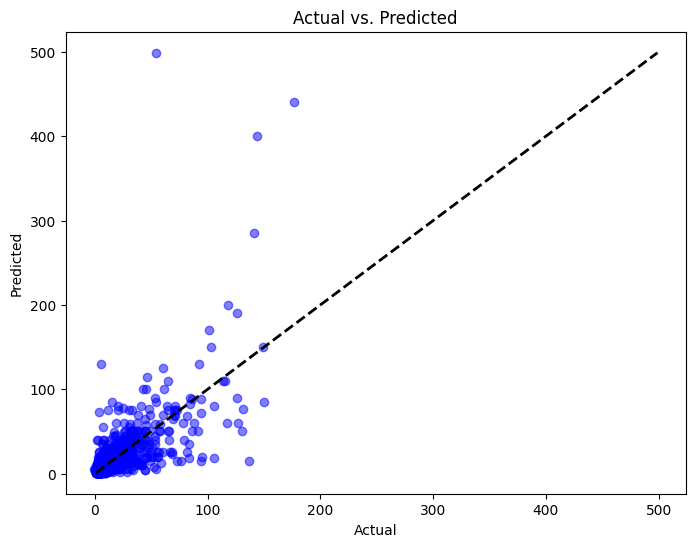

In [48]:
# y_pred/y_test plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), 
          y_test.max()], 
          [y_test.min(), 
           y_test.max()], 
           'k--', 
           lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

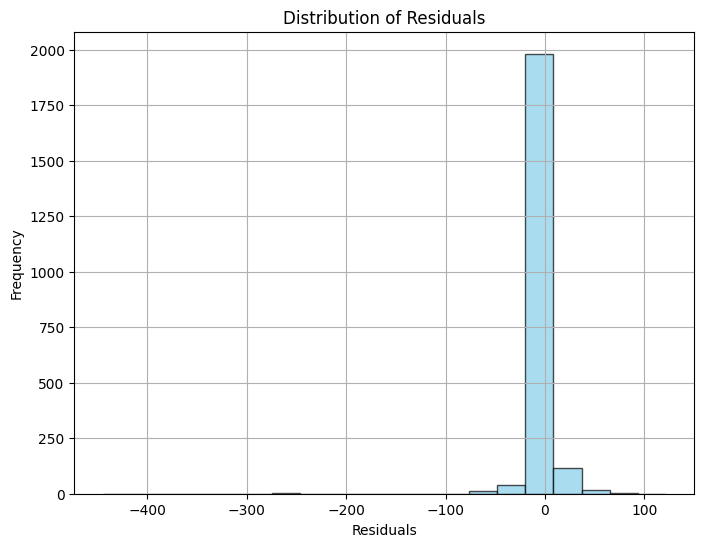

In [49]:
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

### <a id='toc1_3_1_'></a>[Q-Q Plot](#toc0_)

A visual representation of residue normality. The Q-Q plot shows the data doesn't come from a normal distribution because it's tails deviate from the expected quantiles line. This means that the values in our residues are much more extreme than the values we would normally expected from a normal distribution.

This visual method tells us that our residues are within normal distribution range for up to 2 quantiles from the mean, but for extreme values it doesn't belong to the distribution. We can confirm the hypothesis by doing KS test.

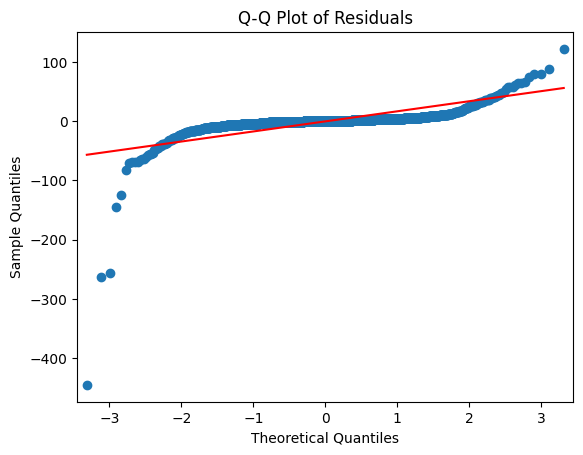

In [50]:
# Q-Q plot of residuals
sm.qqplot(errors, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

### <a id='toc1_3_2_'></a>[Kolmogorov-Smirnov Test](#toc0_)

The null hypothesis ($H_0$​) of the Kolmogorov-Smirnov test is that the two samples are drawn from the same distribution. The alternative hypothesis (H1H1​) is that the two samples are drawn from different distributions.

- Null Hypothesis ($H_0$​): The cumulative distribution functions of the two samples are equal.
- Alternative Hypothesis ($H_1$​): The cumulative distribution functions of the two samples are not equal.

We are going to use the normal distribution as our reference distribution.

In [51]:
ks_test_stat, ks_p_value = kstest(errors, 'norm')
print("\nKolmogorov-Smirnov Test:")
print("Test Statistic:", ks_test_stat)
print("p-value:", ks_p_value)


Kolmogorov-Smirnov Test:
Test Statistic: 0.3344576937269451
p-value: 1.0081601321175741e-217


We reject the null hypothesis that the errors are normaly distributed. (p-value < 0.05 (alfa))

In [52]:
# Calculate error scores for different values in brand_title and catalog_id
error_scores = {}
#for label in ['brand_title', 'catalog_id']:
unique_values = X_test["brand_title"].unique()
for value in unique_values:
    mask = X_test["brand_title"] == value
    error_scores[("brand_title", value)] = mean_squared_error(y_test[mask], y_pred[mask])

# Print error scores
for (label, value), error_score in error_scores.items():
    print(f"Mean Squared Error for brand_title '{value}': {error_score}")

Mean Squared Error for brand_title 'no_brand': 56.30853658536585
Mean Squared Error for brand_title 'Zara': 25.053846153846155
Mean Squared Error for brand_title 'adidas': 2723.378048780488
Mean Squared Error for brand_title 'Shein': 7.741935483870968
Mean Squared Error for brand_title 'H&M': 28.118279569892472
Mean Squared Error for brand_title 'Local': 37.625
Mean Squared Error for brand_title 'Ralph Lauren': 149.97826086956522
Mean Squared Error for brand_title 'Nike': 1334.4285714285713
Mean Squared Error for brand_title 'The North Face': 76.625
Mean Squared Error for brand_title 'Mango': 47.94117647058823
Mean Squared Error for brand_title 'Kiabi': 3.7777777777777777
Mean Squared Error for brand_title 'Donna': 6.888888888888889
Mean Squared Error for brand_title 'Jennyfer': 9.45
Mean Squared Error for brand_title 'Levi's': 49.67857142857143
Mean Squared Error for brand_title 'sans marque': 8.4375
Mean Squared Error for brand_title 'Champion': 170.5
Mean Squared Error for brand_tit

In [62]:
error_scores = {}
unique_values = X_test["catalog_id"].unique()
for value in unique_values:
    mask = X_test["catalog_id"] == value
    error_scores[("catalog_id", value)] = mean_squared_error(y_test[mask], y_pred[mask])

for (label, value), error_score in error_scores.items():
    print(f"Mean Squared Error for catalog_id '{value}': {error_score}")

Mean Squared Error for catalog_id '534': 7.555555555555555
Mean Squared Error for catalog_id '1065': 18.948275862068964
Mean Squared Error for catalog_id '1204': 188.6153846153846
Mean Squared Error for catalog_id '2364': 6.706521739130435
Mean Squared Error for catalog_id '222': 62.39393939393939
Mean Squared Error for catalog_id '228': 10.458333333333334
Mean Squared Error for catalog_id '1043': 7.7407407407407405
Mean Squared Error for catalog_id '1042': 3.526315789473684
Mean Squared Error for catalog_id '2349': 138.93548387096774
Mean Squared Error for catalog_id '163': 4.066666666666666
Mean Squared Error for catalog_id '1806': 18.272727272727273
Mean Squared Error for catalog_id '2337': 112.06060606060606
Mean Squared Error for catalog_id '1821': 141.72222222222223
Mean Squared Error for catalog_id '1242': 5884.962962962963
Mean Squared Error for catalog_id '196': 33.86538461538461
Mean Squared Error for catalog_id '267': 136.55555555555554
Mean Squared Error for catalog_id '180

## <a id='toc1_4_'></a>[Analysis of the results](#toc0_)

### <a id='toc1_4_1_'></a>[SHapley Additive exPlanations](#toc0_)

SHAP or SHapley Additive exPlanations is a model agnostic framework which provides interpretability into individual models and feature importance. In short, SHAP accounts for the marginal contribution of each feature to the prediction scores.

We use TreeExplainer because it is used for explaining predictions from tree based models such as LightGBM.

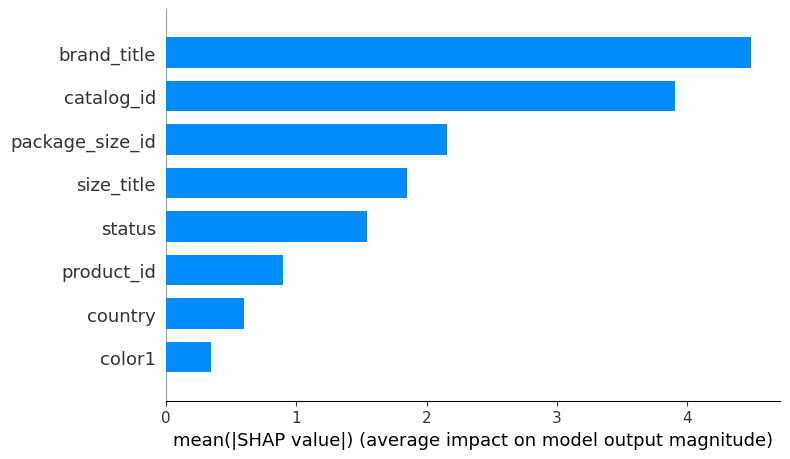

In [54]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values, columns= X_test.columns).apply(np.abs).mean(axis = 0)
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  plot_type = "bar")

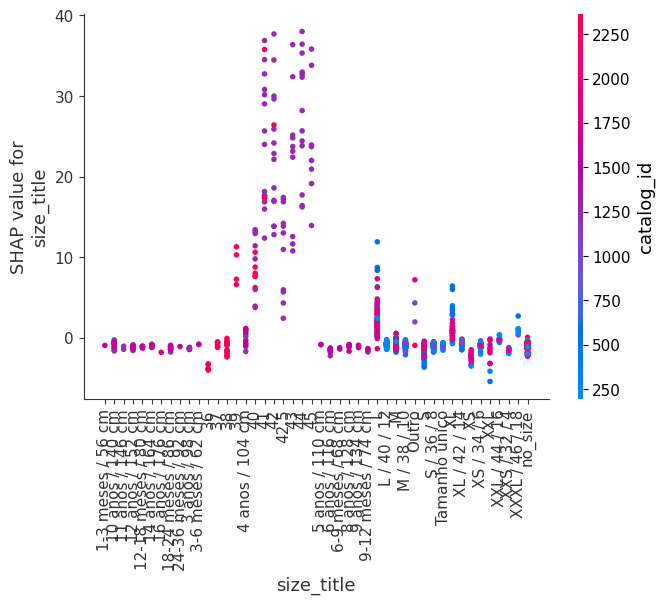

In [55]:
shap.dependence_plot("size_title", shap_values, X_test, interaction_index="catalog_id")

### <a id='toc1_4_2_'></a>[Conclusions](#toc0_)

- We developed a model with around 200-300 RMSE
- Our model doesn't yield robust results, as they vary a lot between runs
- As expected, one of the best predictors to price is brand title followed by the product catalog.
- The SHAP values per size_title with biggest value are linked to shoe sizes
- The SHAP values per size_title with biggest negative value are linked to women sizes
- In order to optimize revenue brand_title and catalogs are by far the best predictors of future revenue

Note: It's really tough to say which size title predicts higher price because there are a lot of confounding variables (namely product catalogs).

## <a id='toc1_5_'></a>[Future work](#toc0_)

- Preprocess the country labels into unique labels (France = Francia)
- Add cross validation to get more robust results
- Add hyperparam tuning
- Add stratified sampling and minimum size per labels in the SQL queries
- Do a small preprocessing step per each catalog